# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Loading

In [2]:
stream_df = pd.read_csv('datasets/tracks_df_cleaned.csv')
print(stream_df.shape)

(129393, 24)


# Feature Engineering

## converting rows into its appropriate dtype

In [3]:
# get the columns that we might need only
stream_df = stream_df[['track_id', 'local_year', 'local_month', 'local_date', \
                        'artist_name', 'track_name', 'ms_played', 'duration_ms']].copy()

In [4]:
stream_df.columns

Index(['track_id', 'local_year', 'local_month', 'local_date', 'artist_name',
       'track_name', 'ms_played', 'duration_ms'],
      dtype='object')

In [5]:
stream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129393 entries, 0 to 129392
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   track_id     129393 non-null  object
 1   local_year   129393 non-null  int64 
 2   local_month  129393 non-null  int64 
 3   local_date   129393 non-null  int64 
 4   artist_name  129393 non-null  object
 5   track_name   129393 non-null  object
 6   ms_played    129393 non-null  int64 
 7   duration_ms  129393 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 7.9+ MB


In [6]:
# convert the column into its appropriate data type
stream_df['local_date'] = stream_df['local_date'].astype(str).str.zfill(2)
stream_df['local_month'] = stream_df['local_month'].astype(str).str.zfill(2)
stream_df['local_year'] = stream_df['local_year'].astype(str)

stream_df['local_datetime'] = pd.to_datetime(stream_df['local_year'] + '-' + stream_df['local_month'] + '-' + stream_df['local_date'])
stream_df.drop(['local_year', 'local_month', 'local_date'], axis=1, inplace=True)

In [12]:
# aggregate the data into daily
agg_stream_df = stream_df.groupby(['local_datetime', 'track_id']).agg(
    {
        'artist_name': 'first',
        'track_name': 'first',
        'duration_ms': 'first',
        'ms_played': 'sum'
    }
).reset_index()

# calculate the ms_played_ratio
agg_stream_df['ms_played_ratio'] = agg_stream_df['ms_played'] / agg_stream_df['duration_ms']

In [13]:
agg_stream_df.shape

(56168, 7)

## (optional) further cleaning

In [14]:
# there are some rows with 0 duration_ms which is not possible, so we will remove them
agg_stream_df = agg_stream_df[~((agg_stream_df['duration_ms'] == 0) | (agg_stream_df['ms_played_ratio'] == np.inf))].copy()

In [15]:
print(agg_stream_df.shape)

(56166, 7)


## identifying 'churn' criteria

In [16]:
agg_stream_df.sample(5)

,local_datetime,track_id,artist_name,track_name,duration_ms,ms_played,ms_played_ratio
25064,2020-07-13,2sekwUeZc97gGIcB0RVYBB,sad boy with a laptop,False Oasis,167190,167190,1.000000
28726,2021-01-12,4b7k4nNURGCRKlZqHXQV5g,Darren Korb,Mouth of Styx,466133,466118,0.999968
37636,2022-01-05,08RAd7JCZsIGOBHWj7bIXQ,Us The Duo,What Is Love,201310,201310,1.000000
25810,2020-08-05,3eYHhoaTGFYJ5XAjRFduUd,A Look At Yesterday,Who's That Knocking,137920,25541,0.185187
10950,2018-08-20,6g93YtKKHU2H1qIqhLIL0Y,Aimer,カタオモイ,207360,207360,1.000000


In [17]:
# calculate the difference between consecutive stream for each track daily
def calculate_differences(df):
    df['prev_play_time'] = df.groupby('track_id')['local_datetime'].shift(1)
    df['time_diff'] = df['local_datetime'] - df['prev_play_time']

    df['prev_ms_played'] = df.groupby('track_id')['ms_played'].shift(1)
    df['duration_change'] = df['ms_played'] - df['prev_ms_played']
    
    df['prev_ratio'] = df.groupby('track_id')['ms_played_ratio'].shift(1)
    df['ratio_change'] = df['ms_played_ratio'] - df['prev_ratio']
    
    return df

In [19]:
agg_stream_interactions = calculate_differences(agg_stream_df.copy())
agg_stream_interactions.sample(5)

,local_datetime,track_id,artist_name,track_name,duration_ms,ms_played,ms_played_ratio,prev_play_time,time_diff,prev_ms_played,duration_change,prev_ratio,ratio_change
5420,2017-10-07,3b1gPWKiAsWXe6bPjE2rm1,Four Tet,My Angel Rocks Back And Forth,307333,5999,0.019520,NaT,NaT,NaN,NaN,NaN,NaN
21669,2020-02-02,50ZYOlB1HZqYZTzhUhOr3f,frad,The Girl I Have a Crush On,137534,2341,0.017021,2020-01-08,25 days,275399.0,-273058.0,2.002407,-1.985385
41012,2022-08-04,40xywqW4aDWTdh8OIY3ZfT,Wasia Project,Burning Eyes R Calling,313491,73153,0.233350,2022-08-03,1 days,335851.0,-262698.0,1.071326,-0.837976
20668,2019-12-24,50ZYOlB1HZqYZTzhUhOr3f,frad,The Girl I Have a Crush On,137534,137534,1.000000,2019-12-21,3 days,137534.0,0.0,1.000000,0.000000
1069,2017-03-22,5IJbTPhcj0IjdzUaYqwe2I,Pink Guy,Stfu,224493,224493,1.000000,2017-03-21,1 days,675298.0,-450805.0,3.008103,-2.008103


In [20]:
time_diff_days = agg_stream_interactions['time_diff'].dropna().dt.days
time_diff_days[time_diff_days < 30].describe()


count    45827.000000
mean         4.018308
std          5.126654
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         29.000000
Name: time_diff, dtype: float64

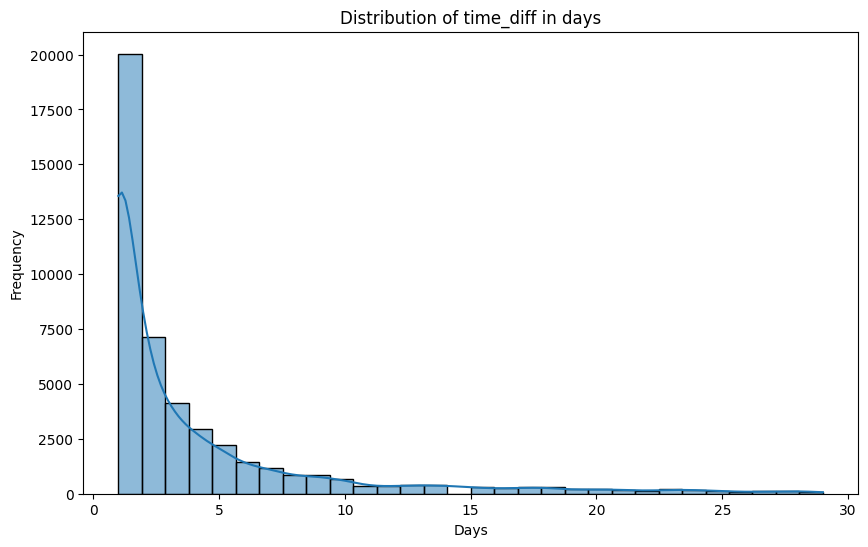

In [21]:
# visualize the distribution of time_diff with less than 30 days
plt.figure(figsize=(10, 6))
sns.histplot(time_diff_days[time_diff_days < 30], bins=30, kde=True)
plt.title('Distribution of time_diff in days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

In [22]:
agg_stream_interactions[(agg_stream_interactions['ratio_change'] < 0) &
                    (agg_stream_interactions['ratio_change'] > -10)]['ratio_change'].describe()

count    18584.000000
mean        -1.367194
std          1.502783
min         -9.999871
25%         -1.731661
50%         -0.999925
75%         -0.573260
max         -0.000003
Name: ratio_change, dtype: float64

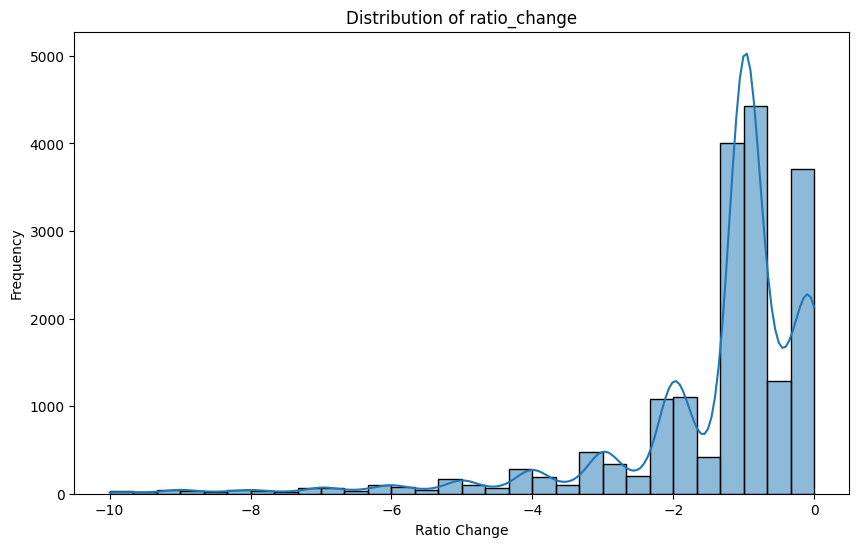

In [23]:
# Visualize the distribution of ratio_change
plt.figure(figsize=(10, 6))
filtered_data = agg_stream_interactions[(agg_stream_interactions['ratio_change'] > -10) 
                                    & (agg_stream_interactions['ratio_change'] < 0)]
sns.histplot(filtered_data['ratio_change'], bins=30, kde=True)
plt.title('Distribution of ratio_change')
plt.xlabel('Ratio Change')
plt.ylabel('Frequency')
plt.show()
